In [1]:
from tqdm import tqdm
import mediapipe as mp
import os
import shutil
import json
import time
from util.ioUtil import *
import numpy as np
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
import parselmouth
from IPython.display import Audio

In [2]:
snd = parselmouth.Sound("/Volumes/EVAN_DISK/ten_videos/Child_in_time/Child_in_time_2/audio.mp3")
time_step = 0.01 # pitch estimated at 100 Hz, not bad 
pitch_ceiling = 1000
pitch = snd.to_pitch(time_step = time_step, pitch_ceiling = pitch_ceiling)

In [3]:
def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")
    
# upper_lip_top = 0
def get_lip_shapes(mp_arr):
    upper_lip_bottom = 13
    lower_lip_top = 14
    # lower_lip_bottom = 17
    left_lip = 292
    right_lip = 62

    lip_parameters = [upper_lip_bottom, lower_lip_top, left_lip, right_lip]
    vertical_openning = np.linalg.norm(mp_arr[:,lip_parameters[0]] - mp_arr[:,lip_parameters[1]], axis=1)
    vertical_openning = (vertical_openning - vertical_openning.min())/(vertical_openning.max() - vertical_openning.min())
    horizontal_openning = np.linalg.norm(mp_arr[:,lip_parameters[2]] - mp_arr[:,lip_parameters[3]], axis=1)
    horizontal_openning = (horizontal_openning - horizontal_openning.min())/(horizontal_openning.max() - horizontal_openning.min())
    return [vertical_openning, horizontal_openning]
def get_subarray_from_time_interval(interval, xs, ys):
    x_vals_low = [-1, -1]
    for i in range(0, xs.shape[0]):
#         x_vals_low.append(xs[i])
        if xs[i] >= interval[0]:
            x_vals_low[0] = i
            break
    for i in range(0, xs.shape[0]):
#         x_vals_low.append(xs[i])
        if xs[i] <= interval[1] and x_vals_low[0] != -1:
            x_vals_low[1] = i
    new_xs = xs[x_vals_low[0]:x_vals_low[1]]
    new_ys = ys[x_vals_low[0]:x_vals_low[1]]
    return new_xs, new_ys

In [4]:
landmarks_path = "/Volumes/EVAN_DISK/ten_videos/Child_in_time/Child_in_time_2/mediapipe_landmark.npy"
land_marks = np.load(landmarks_path)
v_arr, h_arr = get_lip_shapes(land_marks)

29.97002997002997


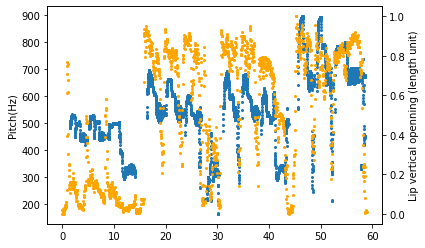

In [5]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

pitch_values = pitch.selected_array['frequency']
pitch_values[pitch_values>=1000] = np.nan
pitch_values[pitch_values==0] = np.nan
ax_left.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
ax_left.plot(pitch.xs(), pitch_values, 'o', markersize=2)
ax_left.set_ylabel("Pitch(Hz)")
ax_right.set_ylabel("Lip vertical openning (length unit)")
ax_left.grid(False)
# plt.ylim(0, pitch.ceiling)
with open("/Volumes/EVAN_DISK/ten_videos/Child_in_time/Child_in_time_2/other_info.json") as f:
    fps_video = json.load(f)["fps"]
print(fps_video)
time = 0;
lip_xs = []
for i in range(0, len(v_arr)):
    time = time + 1/fps_video
    lip_xs.append(time)

# ax_left.plot(left_data, color='black')
ax_right.plot(np.array(lip_xs), v_arr, 'o', markersize=2, color = "orange")

# De-noise the pitch prediction

In [6]:
pitch = snd.to_pitch(time_step = time_step, pitch_ceiling = 1000)

strength = pitch.selected_array["strength"]
frequency = pitch.selected_array["frequency"]

In [7]:
frequency[strength < 0.5] = 0
frequency[frequency==0] = np.nan

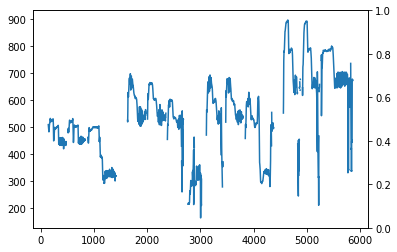

In [8]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.plot(frequency)

### Savgol filter testing

In [9]:
from scipy.signal import savgol_filter, correlate

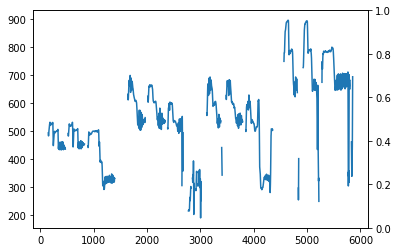

In [10]:
smoothed_pitch = savgol_filter(frequency, 15, 5)
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.plot(smoothed_pitch)

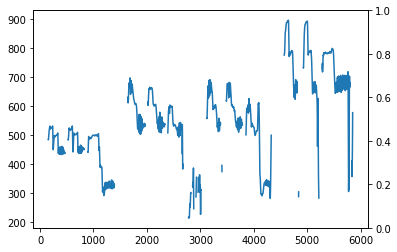

In [11]:
smoothed_pitch = savgol_filter(frequency, 21,5) # 21 time steps corresponds to 1 second, we assume 5 inflection in a second
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.plot(smoothed_pitch)

### Obtain the interval where the vibrato happens using zero crossing

In [12]:
frequency.shape

(5888,)

In [13]:
dt = pitch.xs()[1] - pitch.xs()[0]
frequency_xs = pitch.xs()
d_frequency_dt = correlate(frequency, np.array([-1.0, 0, 1.0]), mode="same")/dt/2

min_zero_crossing_distance = 1.0/14 # max vibrato frequency = 7 Hz = 14 zero crossings per second
tolerance = dt * 2.5 # using the uncertainty of the instrument (pitch measuring device) to bound tolerance

zero_crossing = []
for i in range(0, d_frequency_dt.shape[0]-1):
    if (d_frequency_dt[i] < 0 and d_frequency_dt[i+1] >= 0) or (d_frequency_dt[i] > 0 and d_frequency_dt[i+1] <= 0):
        zero_crossing.append(i+1)
distance = 0
in_vibrato = 0
starting_time = -1
ending_time = -1

vibrato_intervals = []
for i in range(0, len(zero_crossing)-1):
    current_distance = frequency_xs[zero_crossing[i+1]] - frequency_xs[zero_crossing[i]]
    
    if abs(current_distance - distance) <= tolerance and current_distance >= min_zero_crossing_distance:
        if in_vibrato == 0:
            starting_time = zero_crossing[i-1]
            distance = (distance + current_distance) / 2 # calculate new average
            in_vibrato = 1
        elif in_vibrato > 0:
            distance = (distance * in_vibrato + current_distance) / (in_vibrato + 1) # calculate new average
            in_vibrato = in_vibrato + 1
    else:
        if in_vibrato > 0:
            distance = current_distance
            if in_vibrato > 2:
                vibrato_intervals.append([frequency_xs[starting_time], frequency_xs[zero_crossing[i]]])
            in_vibrato = 0
        else:
            distance = current_distance

In [24]:
### store the intensity values in textgrid
import textgrids

### this do not have to be included in the function
output_path = "/Volumes/EVAN_DISK/Speech_data_set/alignment_test"
new_grid = textgrids.TextGrid() # initialize new_textgrid object
new_grid.xmin = 0
new_grid.xmax = frequency_xs[-1]
### this do not have to be included in the function
print(new_grid)
new_grid["vibrato"] = []
for i in range(0, len(vibrato_intervals)):
    interval = textgrids.Interval("vibrato", vibrato_intervals[i][0], vibrato_intervals[i][1])
    new_grid["vibrato"].append(interval)
# new_grid.write(output_path + "/child_in_time_2_vibrato.TextGrid")

File type = "ooTextFile"
Object class = "TextGrid"

xmin = 0
xmax = 58.89403628117914
tiers? <exists>
size = 0
item []:


In [23]:
new_grid

AttributeError: 'list' object has no attribute 'is_point_tier'

In [ ]:
plt.plot(d_frequency_dt)
plt.plot(frequency)

In [16]:
x, y = get_subarray_from_time_interval([3.3, 4.3], pitch.xs(), d_frequency_dt)

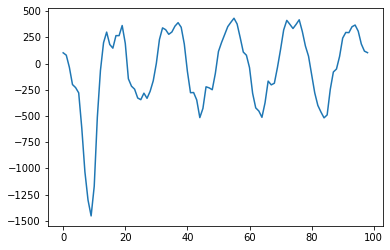

In [17]:
plt.plot(y)

# Formant Analysis of Belting vs Head voice

In [62]:
from scipy.interpolate import interp1d
snd = parselmouth.Sound("/Volumes/EVAN_DISK/ten_videos/rolling_in_the_deep/rolling_in_the_deep_2/audio_vocals.wav")

In [71]:
formant = snd.to_formant_burg(time_step = dt)
pitch = snd.to_pitch(time_step = time_step, pitch_ceiling = 1000)
strength = pitch.selected_array["strength"]
frequency = pitch.selected_array["frequency"]
print(strength.shape)

(1995,)


In [77]:
# print(formant.get_value_at_time(1, 0.2))
# print(formant.get_bandwidth_at_time(1, 0.2))
xs = formant.xs()
formant_arr = np.zeros((len(xs), 3))
for i in range(0, formant_arr.shape[0]):
    for j in range(1, 4):
        formant_arr[i, j-1] = formant.get_value_at_time(j, xs[i])

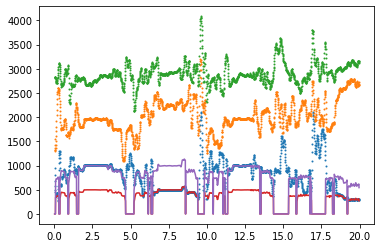

In [78]:
smooth_formant_arr = np.zeros(formant_arr.shape)
for i in range(0, 3):
    smooth_formant_arr[:, i] = savgol_filter(formant_arr[:, i], 21, 3)
for i in range(0, 3):
    plt.plot(formant.xs(), smooth_formant_arr[:, i], "o", markersize=1)

formant_1_2_distance = smooth_formant_arr[:, 1] - smooth_formant_arr[:, 0]
plt.plot(pitch.xs(), frequency)
plt.plot(pitch.xs(), frequency * 2)

In [90]:
H2_F1 = np.abs(frequency * 2 - smooth_formant_arr[:, 0])
f = interp1d(xs, H2_F1)

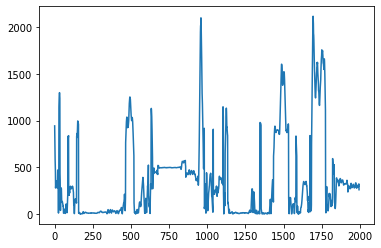

In [82]:
plt.plot(H2_F1)

In [87]:
phoneme_alignment = textgrids.TextGrid("/Volumes/EVAN_DISK/Speech_data_set/alignment_test/alignment_output/rolling_in_the_deep_2_for_killian.TextGrid")

In [101]:
VOWELS = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH',
                      'EY', 'IH', 'IY', 'OW', 'OY',
                      'UH', 'UW'])
belting_intervals = []
head_voice_intervals = []
for item in phoneme_alignment["phones"]:
    if item.text in VOWELS:
        vowel_span = np.arange(item.xmin, item.xmax, dt)
        H2_F1_i = f(vowel_span)
        if H2_F1_i.mean() <= 50:
            belting_intervals.append([item.xmin, item.xmax])
        else:
            head_voice_intervals.append([item.xmin, item.xmax])

In [103]:
phoneme_alignment["phones"][0]

<Interval text="W" xmin=0.08 xmax=0.112>

In [109]:
phoneme_alignment["voice_quality"] = textgrids.Tier()
for item in belting_intervals:
    interval = textgrids.Interval("belt", item[0], item[1])
    phoneme_alignment["voice_quality"].append(interval)
for item in head_voice_intervals:
    interval = textgrids.Interval("head", item[0], item[1])
    phoneme_alignment["voice_quality"].append(interval)
phoneme_alignment.write("/Volumes/EVAN_DISK/Speech_data_set/alignment_test/alignment_output" + "/rolling_in_the_deep_2_voice_quality.TextGrid")